# Cascade Click Model に適用する Bandit Algorithms 実装

In [219]:
import math
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from tqdm import tqdm

In [220]:
np.random.seed(0)

## CascadeUCB

In [221]:
class CascadingModelEnv():
	def __init__(self, E: list[float]):
		self.E = E

	def click(self, A: list[int]) -> int:
		for i, item in enumerate(A):
			if self.E[item] > np.random.random():
				return i+1
		return -1
	
	def opt(self, k: int) -> list[int]:
		return sorted(range(len(self.E)), key=lambda i: self.E[i], reverse=True)[:k]

[3, 2]


(array([495.,   0.,   0.,   0.,   0., 104.,   0., 171.,   0., 230.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <BarContainer object of 10 artists>)

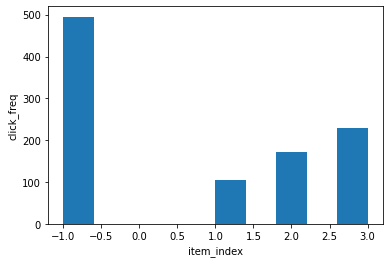

In [222]:
## test
E = [0, 0.1, 0.2, 0.3]
env = CascadingModelEnv(E)

results = []
for i in range(1000):
	results.append(env.click([1,2,3]))

print(env.opt(k=2))

plt.xlabel("item_index")
plt.ylabel("click_freq")
plt.hist(results)

In [223]:
class CascadeUCBAgent(object):
  def __init__(self, E: list[float], p: float):
    self.t = 1
    self.counts = [1 for _ in range(len(E))]
    self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

  def ucb(self, e: int):
    return self.weights[e] + math.sqrt(1.5*math.log(self.t - 1)/self.counts[e])

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    ucbs = [self.ucb(e) for e in range(len(E))]
    return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

  def is_click(self, click: int, k: int) -> int:
    return 1 if click == k else 0

  def observe(self, a: list[int], click : int) -> None:
    if click == -1:
      click = len(a)

    for i in range(min(len(a), click)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.is_click(click, i+1) ) / self.counts[e]

In [225]:
E = [0.4, 0.2, 0.2, 0.1, 0.1, 0.3, 0.2, 0.1, 0.3, 0.1]
env = CascadingModelEnv(E=E)
optimal = env.opt(k=3)
print(f'optional list: {optimal}')

agent = CascadeUCBAgent(E=E, p=0.2)

for i in range(10000):
	a = agent.get_list(k=3)
	click = env.click(a)
	agent.observe(a, click)

print(f'counts: {agent.counts}')
print(f'weights: {agent.weights}')
print(f'A: {agent.get_list(k=3)}')

optional list: [0, 5, 8]
counts: [6997, 1008, 919, 343, 398, 4852, 1096, 653, 4882, 430]
weights: [0.4886379877090182, 0.41567460317460303, 0.410228509249184, 0.3323615160349855, 0.34673366834170855, 0.47980214344600164, 0.4206204379562044, 0.38744257274119476, 0.48013109381401065, 0.3534883720930233]
A: [8, 5, 0]


In [ ]:
# WIP

def f() -> float:
	return 0
def regret(optimal_a: list[int], a:list[int], w_t: list[float]) -> float:
	return f(optimal_a, w_t) - f(a, w_t)

## CombCascade

In [226]:
class MultiClicksModelEnv():
	def __init__(self, E: list[float]):
		self.E = E

	def clicks(self, A: list[int]) -> list[int]:
		clicks = []
		for i, item in enumerate(A):
			if self.E[item] > np.random.random():
				clicks.append(i+1)
		return clicks
	
	def opt(self, k: int) -> list[int]:
		return sorted(range(len(self.E)), key=lambda i: self.E[i], reverse=True)[:k]

In [227]:
class CombCascadeAgent(object):
  def __init__(self, E: list[float], p: float):
    self.t = 1
    self.counts = [1 for _ in range(len(E))]
    self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

  def ucb(self, e: int) -> float:
    return min(self.weights[e] + math.sqrt(1.5*math.log(self.t - 1)/self.counts[e]), 1)

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    ucbs = [self.ucb(e) for e in range(len(E))]
    return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

  def before_no_click(self, no_click: int, k: int) -> int:
    return 1 if k < no_click else 0

  def observe(self, a: list[int], no_click_feedback : int) -> None:
    if no_click_feedback == -1:
      no_click_feedback = len(a)

    for i in range(min(len(a), no_click_feedback)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.before_no_click(no_click_feedback, i+1) ) / self.counts[e]

In [228]:
def first_no_click(a: list[int], clicks: list[int]) -> int:
	if clicks == []:
		return 1

	for i in range(1, len(a)+1):
		try:
			c = clicks[i-1]
		except IndexError:
			return i
		if c == i:
			continue
		return i
	return -1

## debug
# print(first_no_click([4,3,5], [1, 3]))
# print(first_no_click([4,3,5], [1, 2]))
# print(first_no_click([4,3,5], [2]))

In [229]:
E = [0.4, 0.6, 0.7, 0.2, 0.4, 0.6, 0.1, 0.1, 0.3, 0.1]
env = MultiClicksModelEnv(E=E)
optimal = env.opt(k=3)
print(f'optional list: {optimal}')

agent = CombCascadeAgent(E=E, p=0.2)

for i in range(10000):
	a = agent.get_list(k=3)
	clicks = env.clicks(a)
	no_click_feedback = first_no_click(a, clicks)
	agent.observe(a, no_click_feedback)

print(f'counts: {agent.counts}')
print(f'weights: {agent.weights}')
print(f'A: {agent.get_list(k=3)}')

optional list: [2, 1, 5]
counts: [511, 6933, 9951, 523, 523, 612, 511, 534, 557, 511]
weights: [0.003913894324853224, 0.5991634213183312, 0.7005326097879615, 0.0057361376673040095, 0.0057361376673040095, 0.01797385620915036, 0.003913894324853224, 0.007490636704119842, 0.01077199281867144, 0.003913894324853224]
A: [2, 1, 0]


## CascadeLinTS

In [305]:
def gen_items(tags: dict[str, float], L: int)-> pd.DataFrame:
  tag_ids = list(tags.keys())
  weights = []
  features = []
  for i in range(L):
    n = random.randint(1, 3)
    tag_samples = random.sample(tag_ids, n)

    w = 0
    one_hot = []
    for t in tag_ids:
      if t in tag_samples:
        w += random.gauss(tags[t], 0.05)
        one_hot.append(1)
      else:
        one_hot.append(0)
      
    features.append(np.array(one_hot))
    weights.append(w)

  df = pd.DataFrame({'id': list(range(len(weights))),
                      'weight' : weights,
                      'feature' : features})
  return  df

tags_with_weight = {'AWS': 0.1, 'Docker': 0.2,'Elasticsearch': 0.15 ,'GCP': 0.08, 'Git': 0.05, 'NLP': 0.23, 'Rust': 0.3, 'Scala': 0.18, '機械学習': 0.25, '強化学習': 0.2}
df = gen_items(tags=tags_with_weight, L=256)
df.head(5)

,id,weight,feature
0,0,0.488203,"[0, 0, 1, 0, 0, 0, 0, 1, 1, 0]"
1,1,0.493457,"[0, 0, 0, 1, 0, 0, 1, 1, 0, 0]"
2,2,0.681771,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 0]"
3,3,0.130302,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,0.218935,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [302]:
class CascadeLinTSAgent(object):
  def __init__(self, d: int, sigma: float, features: pd.DataFrame):
    self.sigma = sigma
    self.features = features
    self.M = np.eye(d)
    self.B = np.zeros(d)

  def get_list(self, k: int) -> list[int]:
    m_t = self.M.T
    before_theta = (self.sigma**-2) * np.inner(m_t, self.B)
    theta = np.random.multivariate_normal(before_theta, cov=m_t)
    weights = self.features['feature'].apply(lambda x: np.inner(x.T, theta)).to_list()
    return sorted(range(len(weights)), key=lambda i: weights[i], reverse=True)[:k]

  def is_click(self, click: int, k: int) -> int:
    return 1 if click == k else 0

  def observe(self, a: list[int], click : int) -> None:
    if click == -1:
      click = len(a)

    for i in range(min(len(a), click)):
      e = a[i]
      x = self.features[self.features['id']==e]['feature'].to_list()[0]
      self.M = self.M + (self.sigma**-2) * np.inner(x, x.T)
      self.B = self.B + (x * self.is_click(click, i+1))

In [303]:
E = df['weight'].to_list()
env = CascadingModelEnv(E=E)
optimal = env.opt(k=4)
print(f'optional list: {optimal}')

agent = CascadeLinTSAgent(d=len(tags_with_weight), sigma=1, features=df.drop('weight', axis=1))

for i in tqdm(range(100000)):
	a = agent.get_list(k=4)
	click = env.click(a)
	agent.observe(a, click)

print(f'A: {agent.get_list(k=4)}') 

optional list: [23, 80, 11, 249]


100%|██████████| 100000/100000 [03:16<00:00, 509.17it/s]

A: [148, 2, 254, 138]


In [304]:
a = agent.get_list(k=4)

df[df['id'].isin(a)]

,id,weight,feature
2,2,0.416928,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
138,138,0.388992,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
148,148,0.539676,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1]"
254,254,0.449143,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
